# RQ1 and RQ2 Analysis

This notebook analyzes the results from execution `20260113_1103/` for:
- **RQ1**: Operator Effectiveness Analysis
- **RQ2**: Cluster Quality and Diversity Analysis

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

In [2]:
# Load data
output_dir = Path("../data/outputs/20260113_1103")

# Load EvolutionTracker
with open(output_dir / "EvolutionTracker.json", 'r') as f:
    evolution_tracker = json.load(f)

# Load speciation state
with open(output_dir / "speciation_state.json", 'r') as f:
    speciation_state = json.load(f)

# Load elites and reserves
with open(output_dir / "elites.json", 'r') as f:
    elites = json.load(f)

with open(output_dir / "reserves.json", 'r') as f:
    reserves = json.load(f)

print(f"Total generations: {evolution_tracker.get('total_generations', 0)}")
print(f"Total population: {len(elites) + len(reserves)}")
print(f"Active species: {len([s for s in speciation_state.get('species', {}).values() if s.get('species_state') == 'active'])}")

Total generations: 4
Total population: 100
Active species: 11


## RQ1: Operator Effectiveness Analysis

Analyze which variation operators are most effective at generating high-fitness variants.

In [3]:
# Extract operator statistics across all generations
operator_data = defaultdict(lambda: {
    'total_variants': 0,
    'elite_count': 0,
    'non_elite_count': 0,
    'rejections': 0,
    'duplicates': 0,
    'fitness_scores': []
})

for gen in evolution_tracker.get('generations', []):
    gen_num = gen.get('generation_number', 0)
    op_stats = gen.get('operator_statistics', {})
    
    for op_name, stats in op_stats.items():
        operator_data[op_name]['rejections'] += stats.get('question_mark_rejections', 0)
        operator_data[op_name]['duplicates'] += stats.get('duplicates_removed', 0)

print(f"Operators found: {len(operator_data)}")
for op, data in operator_data.items():
    print(f"  {op}: rejections={data['rejections']}, duplicates={data['duplicates']}")

Operators found: 12
  SemanticFusionCrossover: rejections=2, duplicates=1
  MLM: rejections=2, duplicates=4
  LLMBasedParaphrasing: rejections=5, duplicates=1
  StylisticMutator: rejections=3, duplicates=3
  InformedEvolutionOperator: rejections=6, duplicates=0
  SemanticSimilarityCrossover: rejections=0, duplicates=3
  LLM_POSAwareSynonymReplacement: rejections=1, duplicates=5
  POSAwareAntonymReplacement: rejections=0, duplicates=6
  LLMBackTranslation_HI: rejections=1, duplicates=5
  NegationOperator: rejections=2, duplicates=4
  TypographicalErrorsOperator: rejections=2, duplicates=4
  ConceptAdditionOperator: rejections=1, duplicates=5


Saved: ../experiments/figures/rq1_rq2/rq1_operator_rejections_duplicates.png


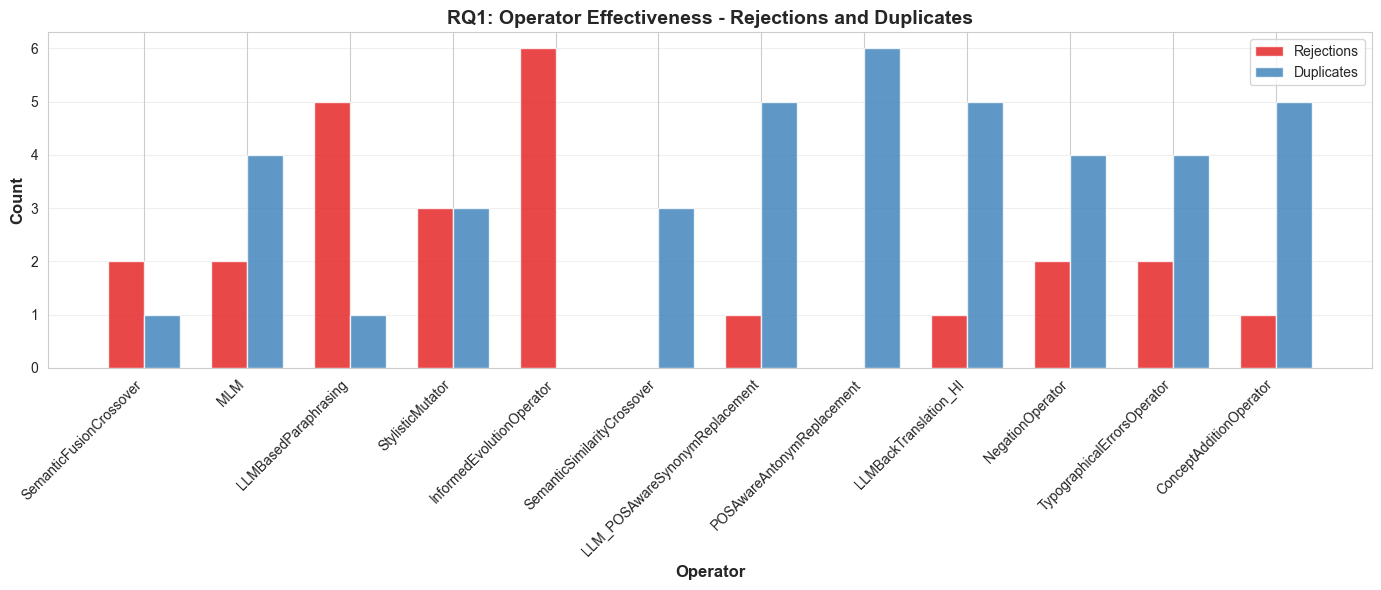

In [4]:
# Create operator effectiveness visualization
if operator_data:
    operators = list(operator_data.keys())
    rejections = [operator_data[op]['rejections'] for op in operators]
    duplicates = [operator_data[op]['duplicates'] for op in operators]
    
    fig, ax = plt.subplots(figsize=(14, 6))
    x = np.arange(len(operators))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, rejections, width, label='Rejections', color='#e41a1c', alpha=0.8)
    bars2 = ax.bar(x + width/2, duplicates, width, label='Duplicates', color='#377eb8', alpha=0.8)
    
    ax.set_xlabel('Operator', fontsize=12, fontweight='bold')
    ax.set_ylabel('Count', fontsize=12, fontweight='bold')
    ax.set_title('RQ1: Operator Effectiveness - Rejections and Duplicates', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(operators, rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    
    # Save figure
    fig_dir = Path("../experiments/figures/rq1_rq2")
    fig_dir.mkdir(parents=True, exist_ok=True)
    plt.savefig(fig_dir / "rq1_operator_rejections_duplicates.png", dpi=300, bbox_inches='tight')
    print(f"Saved: {fig_dir / 'rq1_operator_rejections_duplicates.png'}")
    plt.show()
else:
    print("No operator data available")

## RQ2: Cluster Quality and Diversity Analysis

Analyze the quality and diversity of species clusters.

In [5]:
# Extract speciation metrics across generations
speciation_metrics = []

for gen in evolution_tracker.get('generations', []):
    gen_num = gen.get('generation_number', 0)
    spec = gen.get('speciation', {})
    
    if spec:
        speciation_metrics.append({
            'generation': gen_num,
            'species_count': spec.get('species_count', 0),
            'reserves_size': spec.get('reserves_size', 0),
            'total_population': spec.get('total_population', 0),
            'best_fitness': spec.get('best_fitness', 0.0),
            'avg_fitness': spec.get('avg_fitness', 0.0),
            'inter_species_diversity': spec.get('inter_species_diversity', 0.0),
            'intra_species_diversity': spec.get('intra_species_diversity', 0.0)
        })

spec_df = pd.DataFrame(speciation_metrics)
print("Speciation Metrics:")
print(spec_df.to_string(index=False))

Speciation Metrics:
 generation  species_count  reserves_size  total_population  best_fitness  avg_fitness  inter_species_diversity  intra_species_diversity
          0             11              4               100        0.3032       0.0367                    0.349                   0.2701
          1             11              4               100        0.3032       0.0367                    0.349                   0.2701
          2             11              4               100        0.3032       0.0367                    0.349                   0.2701
          3             11              4               100        0.3032       0.0367                    0.349                   0.2701


Saved: ../experiments/figures/rq1_rq2/rq2_cluster_quality_diversity.png


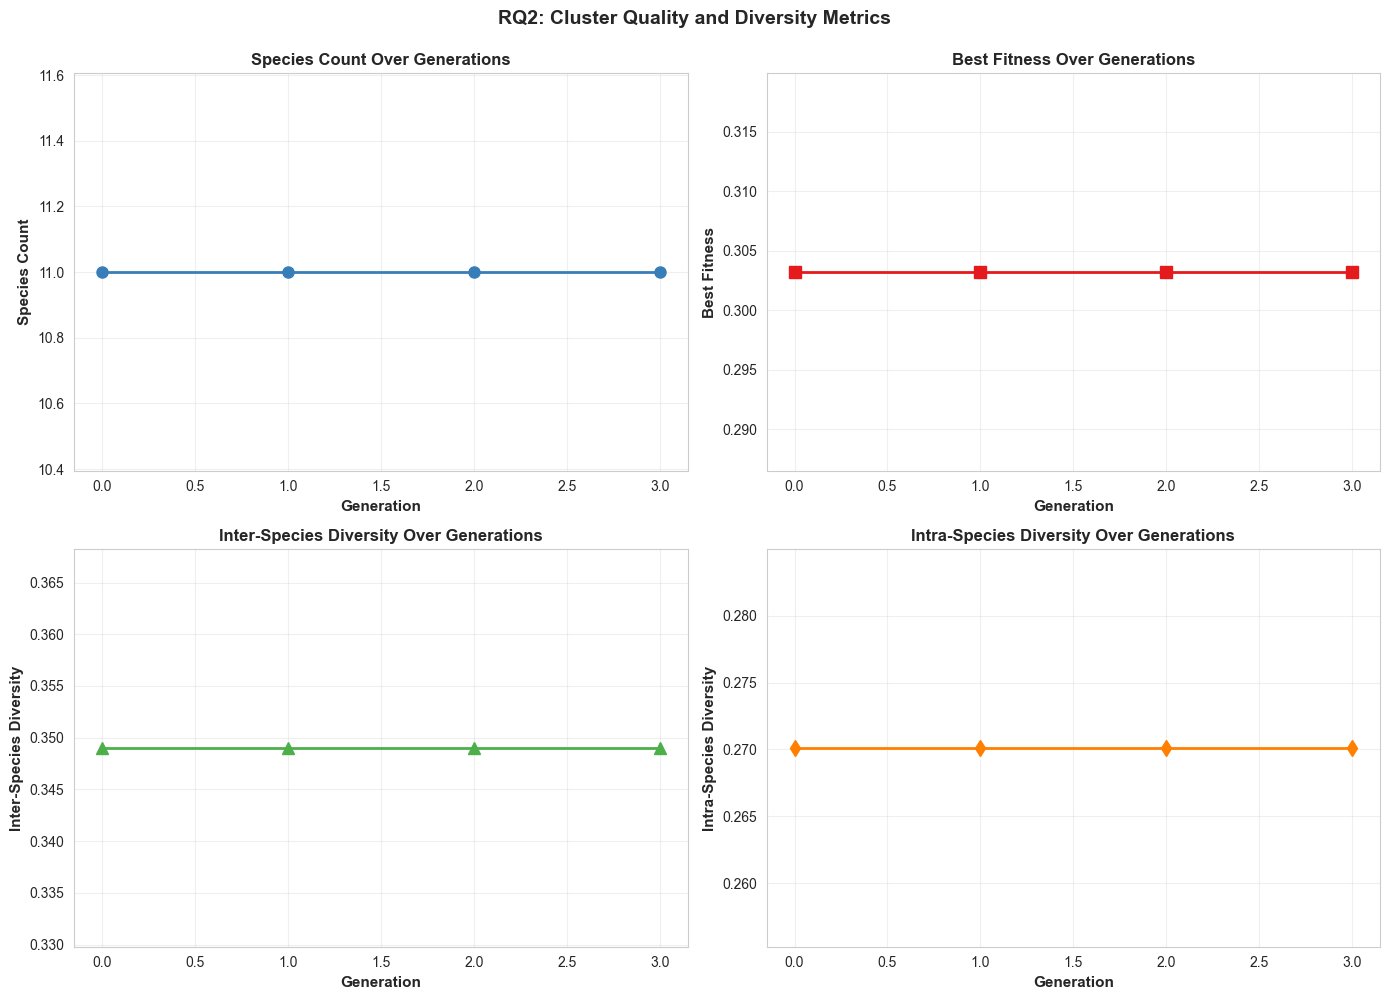

In [6]:
# Plot species evolution
if len(spec_df) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Species count over generations
    axes[0, 0].plot(spec_df['generation'], spec_df['species_count'], 'o-', linewidth=2, markersize=8, color='#377eb8')
    axes[0, 0].set_xlabel('Generation', fontsize=11, fontweight='bold')
    axes[0, 0].set_ylabel('Species Count', fontsize=11, fontweight='bold')
    axes[0, 0].set_title('Species Count Over Generations', fontsize=12, fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Best fitness over generations
    axes[0, 1].plot(spec_df['generation'], spec_df['best_fitness'], 's-', linewidth=2, markersize=8, color='#e41a1c')
    axes[0, 1].set_xlabel('Generation', fontsize=11, fontweight='bold')
    axes[0, 1].set_ylabel('Best Fitness', fontsize=11, fontweight='bold')
    axes[0, 1].set_title('Best Fitness Over Generations', fontsize=12, fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Inter-species diversity
    axes[1, 0].plot(spec_df['generation'], spec_df['inter_species_diversity'], '^-', linewidth=2, markersize=8, color='#4daf4a')
    axes[1, 0].set_xlabel('Generation', fontsize=11, fontweight='bold')
    axes[1, 0].set_ylabel('Inter-Species Diversity', fontsize=11, fontweight='bold')
    axes[1, 0].set_title('Inter-Species Diversity Over Generations', fontsize=12, fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Intra-species diversity
    axes[1, 1].plot(spec_df['generation'], spec_df['intra_species_diversity'], 'd-', linewidth=2, markersize=8, color='#ff7f00')
    axes[1, 1].set_xlabel('Generation', fontsize=11, fontweight='bold')
    axes[1, 1].set_ylabel('Intra-Species Diversity', fontsize=11, fontweight='bold')
    axes[1, 1].set_title('Intra-Species Diversity Over Generations', fontsize=12, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.suptitle('RQ2: Cluster Quality and Diversity Metrics', fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    
    # Save figure
    fig_dir = Path("../experiments/figures/rq1_rq2")
    fig_dir.mkdir(parents=True, exist_ok=True)
    plt.savefig(fig_dir / "rq2_cluster_quality_diversity.png", dpi=300, bbox_inches='tight')
    print(f"Saved: {fig_dir / 'rq2_cluster_quality_diversity.png'}")
    plt.show()
else:
    print("No speciation metrics available")

Saved: ../experiments/figures/rq1_rq2/rq2_species_distributions.png


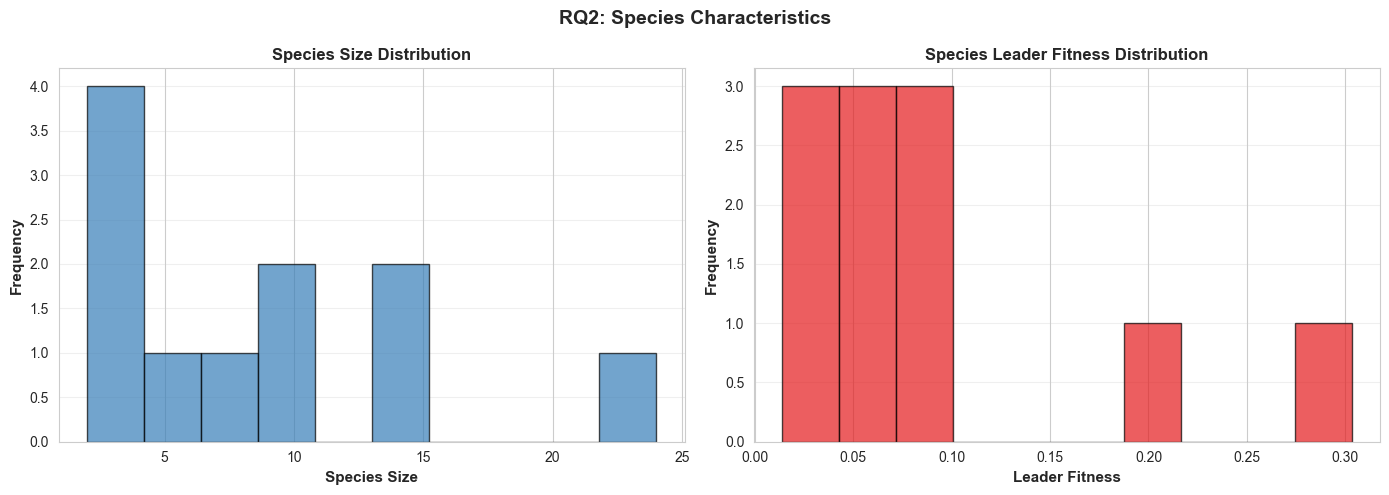


Species Statistics:
  Total active species: 11
  Average size: 8.73
  Min size: 2
  Max size: 24
  Average leader fitness: 0.0918
  Max leader fitness: 0.3032


In [7]:
# Analyze species size distribution
species_sizes = []
species_fitness = []

for sid, sp in speciation_state.get('species', {}).items():
    if sp.get('species_state') == 'active':
        species_sizes.append(sp.get('size', 0))
        species_fitness.append(sp.get('leader_fitness', 0.0))

if species_sizes:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Size distribution
    axes[0].hist(species_sizes, bins=10, color='#377eb8', alpha=0.7, edgecolor='black')
    axes[0].set_xlabel('Species Size', fontsize=11, fontweight='bold')
    axes[0].set_ylabel('Frequency', fontsize=11, fontweight='bold')
    axes[0].set_title('Species Size Distribution', fontsize=12, fontweight='bold')
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # Fitness distribution
    axes[1].hist(species_fitness, bins=10, color='#e41a1c', alpha=0.7, edgecolor='black')
    axes[1].set_xlabel('Leader Fitness', fontsize=11, fontweight='bold')
    axes[1].set_ylabel('Frequency', fontsize=11, fontweight='bold')
    axes[1].set_title('Species Leader Fitness Distribution', fontsize=12, fontweight='bold')
    axes[1].grid(True, alpha=0.3, axis='y')
    
    plt.suptitle('RQ2: Species Characteristics', fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    # Save figure
    fig_dir = Path("../experiments/figures/rq1_rq2")
    fig_dir.mkdir(parents=True, exist_ok=True)
    plt.savefig(fig_dir / "rq2_species_distributions.png", dpi=300, bbox_inches='tight')
    print(f"Saved: {fig_dir / 'rq2_species_distributions.png'}")
    plt.show()
    
    print(f"\nSpecies Statistics:")
    print(f"  Total active species: {len(species_sizes)}")
    print(f"  Average size: {np.mean(species_sizes):.2f}")
    print(f"  Min size: {np.min(species_sizes)}")
    print(f"  Max size: {np.max(species_sizes)}")
    print(f"  Average leader fitness: {np.mean(species_fitness):.4f}")
    print(f"  Max leader fitness: {np.max(species_fitness):.4f}")
else:
    print("No active species found")

## Summary Statistics

In [8]:
print("=" * 60)
print("EXECUTION SUMMARY")
print("=" * 60)
print(f"Total generations: {evolution_tracker.get('total_generations', 0)}")
print(f"Total population: {len(elites) + len(reserves)}")
print(f"  - Elites: {len(elites)}")
print(f"  - Reserves: {len(reserves)}")
print(f"Active species: {len([s for s in speciation_state.get('species', {}).values() if s.get('species_state') == 'active'])}")
print(f"\nBest fitness achieved: {max([g.get('speciation', {}).get('best_fitness', 0.0) for g in evolution_tracker.get('generations', [])]):.4f}")
print(f"\nOperators analyzed: {len(operator_data)}")

EXECUTION SUMMARY
Total generations: 4
Total population: 100
  - Elites: 96
  - Reserves: 4
Active species: 11

Best fitness achieved: 0.3032

Operators analyzed: 12
